In [125]:
from quantum_logical.error_channel import AmplitudeDamping, PhaseDamping
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qutip.metrics import fidelity
import matplotlib.pyplot as plt

In [126]:
T1, Tphi = 1, 1
T2 = 1 / (1 / Tphi + 1 / (2 * T1))
T2 = 1

In [127]:
from qutip import basis

zero_rho = basis(2, 0) * basis(2, 0).dag()  # |0><0|
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1|
plus_rho = (basis(2, 0) + basis(2, 1)).unit() * (
    basis(2, 0) + basis(2, 1)
).unit().dag()  # |+><+|

In [128]:
def apply_error_channel(state, error_channel, delay, trotter_step_size):
    # Calculate the number of trotter steps
    num_steps = int(delay / trotter_step_size)

    for _ in range(num_steps):
        state = error_channel.apply(state)
    return state

In [136]:
def single_qubit_expectations(rho_final):
    """Calculate expectation values of Pauli matrices for a given density matrix."""
    measurements = {"X": sigmax(), "Y": sigmay(), "Z": sigmaz()}
    results = {key: expect(op, rho_final) for key, op in measurements.items()}
    return results


def single_qubit_experiment(rho_initial, delay, trotter_step_size):
    amp_damp_channel = AmplitudeDamping(T1, trotter_step_size)
    phase_damp_channel = PhaseDamping(T2, trotter_step_size)

    # NOTE, we can apply amplitude damping and phase damping in any order
    # because they commute :)

    # Apply the error channel over the entire delay with the given trotter step size
    rho_final = apply_error_channel(
        rho_initial, amp_damp_channel, delay, trotter_step_size
    )

    rho_final = apply_error_channel(
        rho_final, phase_damp_channel, delay, trotter_step_size
    )

    # Calculate expectation values
    expectations = single_qubit_expectations(rho_final)

    # Calculate the fidelity
    fid = fidelity(rho_initial, rho_final)

    return expectations, fid

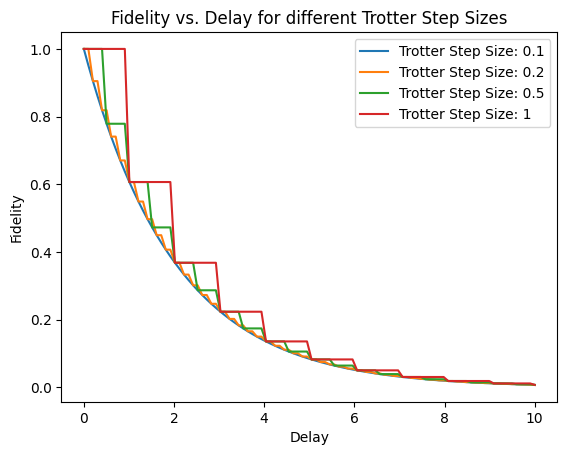

In [137]:
trotter_step_sizes = [0.1, 0.2, 0.5, 1]  # Varying granularities
delays = np.linspace(0, 10, 100)  # Sweeping delay from 0 to 10
initial_state = one_rho

plt.figure()
for step_size in trotter_step_sizes:
    fidelities = [
        single_qubit_experiment(initial_state, delay, step_size)[1] for delay in delays
    ]
    plt.plot(delays, fidelities, label=f"Trotter Step Size: {step_size}")

plt.legend()
plt.xlabel("Delay")
plt.ylabel("Fidelity")
plt.title("Fidelity vs. Delay for different Trotter Step Sizes")
plt.show()

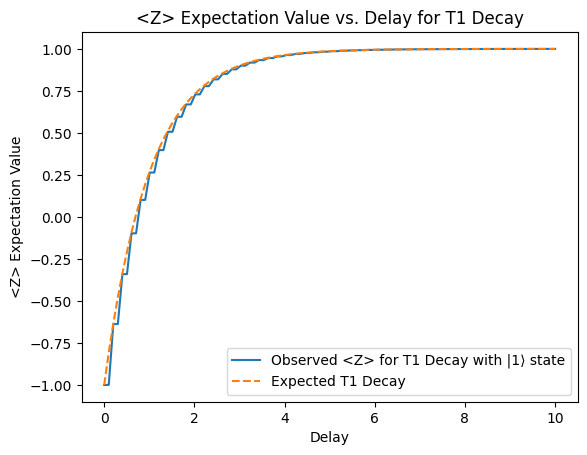

In [138]:
# Expected T1 decay function
def expected_T1_decay(t, T1):
    return 1 - 2 * np.exp(-t / T1)


# Calculate expected values
expected_values_Z_T1 = [expected_T1_decay(delay, T1) for delay in delays]

# For T1 Decay
initial_state_T1 = one_rho  # Assuming this is the |1⟩ state
trotter_step_size = 0.2

results_T1 = [
    single_qubit_experiment(
        initial_state_T1,
        delay,
        trotter_step_size,
    )
    for delay in delays
]

# Extracting expectation values for Z
expectation_values_Z_T1 = [res[0]["Z"] for res in results_T1]

plt.figure()
plt.plot(
    delays, expectation_values_Z_T1, label="Observed <Z> for T1 Decay with |1⟩ state"
)
plt.plot(delays, expected_values_Z_T1, "--", label="Expected T1 Decay")
plt.legend()
plt.xlabel("Delay")
plt.ylabel("<Z> Expectation Value")
plt.title("<Z> Expectation Value vs. Delay for T1 Decay")
plt.show()

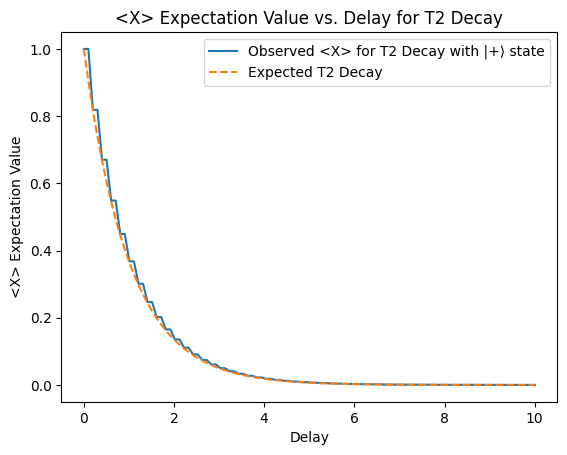

In [141]:
# Expected T2 decay function
def expected_T2_decay(t, T2):
    return np.exp(-t / T2)


# Calculate expected values
expected_values_X_T2 = [expected_T2_decay(delay, T2) for delay in delays]

initial_state_T2 = plus_rho

results_T2 = [
    single_qubit_experiment(
        initial_state_T2,
        delay,
        trotter_step_size,
    )
    for delay in delays
]

# Extracting expectation values for X
expectation_values_X_T2 = [res[0]["X"] for res in results_T2]

plt.figure()
plt.plot(
    delays, expectation_values_X_T2, label="Observed <X> for T2 Decay with |+⟩ state"
)
plt.plot(delays, expected_values_X_T2, "--", label="Expected T2 Decay")
plt.legend()
plt.xlabel("Delay")
plt.ylabel("<X> Expectation Value")
plt.title("<X> Expectation Value vs. Delay for T2 Decay")
plt.show()

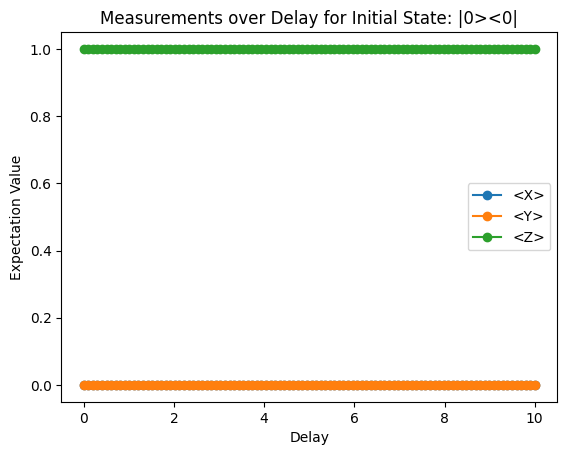

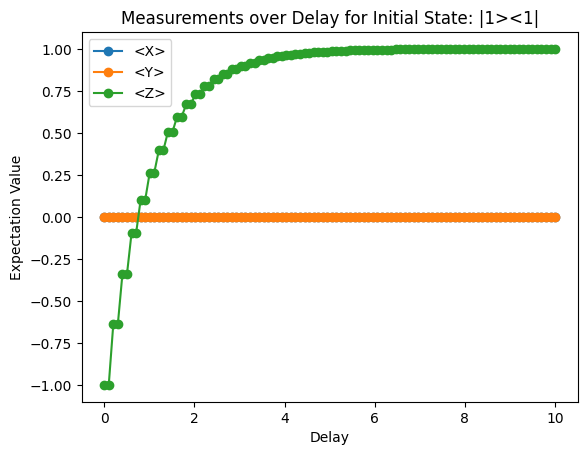

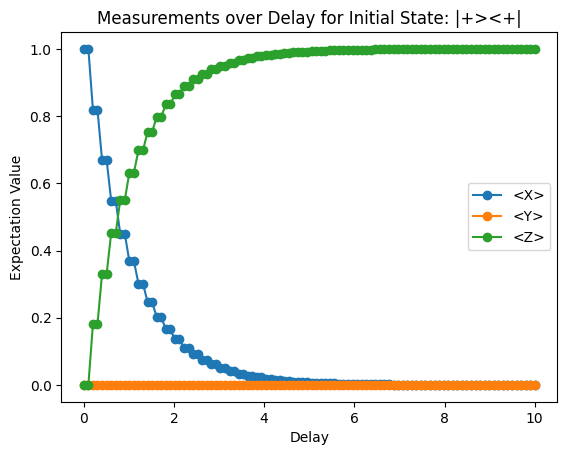

In [142]:
from qutip import expect, tensor, bell_state
from qutip import sigmax, sigmay, sigmaz

trotter_step_size = 0.2


def plot_qubit_decay_for_initial_state(name, state, T1, T2, delays, trotter_step_size):
    plt.figure()

    results = []
    for delay in delays:
        expectations, _ = single_qubit_experiment(state, delay, trotter_step_size)
        results.append(expectations)

    for key in ["X", "Y", "Z"]:
        values = [res[key] for res in results]
        label_str = f"<{key}>"
        plt.plot(delays, values, "-o", label=label_str)

    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title(f"Measurements over Delay for Initial State: {name}")
    plt.legend()
    plt.show()


initial_states = {"|0><0|": zero_rho, "|1><1|": one_rho, "|+><+|": plus_rho}
for name, state in initial_states.items():
    plot_qubit_decay_for_initial_state(name, state, T1, T2, delays, trotter_step_size)